## EDA of international Football Matches

In this notebook we will take a closer look into the evolution of international football matches (i.e. matches played between countries) through the years.

#### Questions to be explored:
- How the international football scenario change over the years?    
    - More games? 
    - Percentage of each continent in the total of games
    - Teams from different continents play with each other more or less today than they did in the past?
    - Did more different teams win games today than in the past? (não existe mais bobo no futebol)


- How is the performance of a winning world cup team in the years the preceed the tournament?
    - How many games?
    - How many wins, losses, draws?
    - How is the performance in the year before the WC?
    - If its a team from America, how many games they played agaist european teams?

    
- How is Brazil comming to this World Cup comparing to the recent World Cups?
    - How many wins, losses, draws?
    - What percentage of the points possible it gets?
    - Whicj continents Brazil played against?


#### Columns of results.csv:
- **date**: Date of the match
- **home_team**: Name of the home team
- **away_team**: Name of the away team
- **home_score**: Home team goals
- **away_score**: Away team goals
- **tournament**: Tournament name
- **city**: City where the match took place
- **country**: Country where the match took place.
- **neutral**: Whether the match took place at a neutral venue or not.

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Start the analysis by reading the results file from the "data" folder
df_results = pd.read_csv("data/results.csv")

# Convert the date column to datetime
df_results['date']  = pd.to_datetime(df_results['date'])

print(f"There are {len(df_results)} matches")
print(f"The first game was {df_results['date'].min().date()} and the last was {df_results['date'].max().date()}")

df_results.head(5)

There are 43752 matches
The first game was 1872-11-30 and the last was 2022-06-14


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [3]:
# Creating some new columns that might be usefull

def get_game_outcome ( home_score, away_score):
    """
    The outcome will be encoded as:
        - D: Draw
        - H: Home team wins
        - A: Away team wins
    """
    if (home_score == away_score):
        return 'D' # Draw
    elif (home_score > away_score):
        return 'H' # Home team wins
    elif (home_score < away_score):
        return 'A' # Away team wins

def winning_team(home_team, away_team, outcome):
    if (outcome == 'H'):
        return home_team
    elif (outcome == 'A'):
        return away_team
    else:
        return '-'

def losing_team(home_team, away_team, outcome):
    if (outcome == 'A'):
        return home_team
    elif (outcome == 'H'):
        return away_team
    else:
        return '-'

# The outcome of the game
df_results['outcome'] = df_results.apply(lambda x: get_game_outcome(x.home_score, x.away_score), axis=1)

# Name of the winning team
df_results['winning_team'] =  df_results.apply(lambda x: winning_team(x.home_team, x.away_team, x.outcome), axis=1)

# Name of the losing team
df_results['losing_team'] =  df_results.apply(lambda x: losing_team(x.home_team, x.away_team, x.outcome), axis=1)

# Score difference
df_results['score_difference'] = df_results.apply(lambda x: abs(x.home_score - x.away_score), axis=1)

# Teams envolved on the match
df_results['teams_envolved'] = df_results.apply(lambda x: [x.home_team, x.away_team], axis = 1)

# Year of the game
df_results['year'] = df_results['date'].apply(lambda x: x.year)

# Month of the game
df_results['month'] = df_results['date'].apply(lambda x: x.month_name())

# Day of the game
df_results['day'] = df_results['date'].apply(lambda x: x.day)

# Day of the week of the game
df_results['day_name'] = df_results['date'].apply(lambda x: x.day_name())

# The home team actually play at home?
df_results['home_playing_home'] = df_results.apply(lambda x: 'y' if x.home_team == x.country else 'n', axis = 1)

df_results['date'] = df_results['date'].apply(lambda x: x.date())

In [4]:
df_geo_regions = pd.read_csv('data/geographic-regions.csv')
df_geo_regions.fillna('-', inplace = True)
df_geo_regions.rename(columns = {'Country or Area':'country_reff', 'Region Name':'continent'}, inplace = True)

missing_countries_dict = {
                            'England':'Europe',
                            'Scotland':'Europe',
                            'Wales':'Europe',
                            'Turkey':'Europe',
                            'Tanzania':'Africa',
                            'China PR':'Asia',
                            'Republic of Ireland':'Europe',
                            'Iran':'Asia',
                            'Northern Ireland':'Europe',
                            'Russia':'Europe',
                            'Ivory Coast':'Africa',
                            'Yugoslavia':'Europe',
                            'Hong Kong':'Asia',
                            'Bolivia':'Americas',
                            'Czechoslovakia':'Europe',
                            'Venezuela':'Americas',
                            'Soviet Union':'Europe',
                            'Czech Republic':'Europe',
                            'Vietnam':'Asia',
                            'German DR':'Europe',
                            'Syria':'Asia',
                            'Malaya':'Asia',
                            'Moldova':'Europe',
                            'DR Congo':'Africa',
                            'Cape Verde':'Africa',
                            'Netherlands Antilles':'Americas',
                            'Vietnam Republic':'Asia',
                            'Zaïre':'Africa',
                            'Taiwan':'Asia',
                            'Laos':'Asia'
}

def get_continent ( label, df_results ):
    df_merged = df_results.merge(df_geo_regions[['country_reff','continent']], how = 'left', left_on =label, right_on = 'country_reff')
    df_merged['continent'] = df_merged['continent'].fillna('-')
    return df_merged.apply(lambda x: missing_countries_dict.get(x[label], "not found") if x.continent == '-' else x.continent, axis=1 )

# Get the continent of the game, the away_team and the home_team
df_results['game_continent'] = get_continent ( 'country', df_results )
df_results['home_team_continent'] = get_continent ( 'home_team', df_results )
df_results['away_team_continent'] = get_continent ( 'away_team', df_results )

# The home team is playing in their continent?
df_results['home_playing_continent'] = df_results.apply(lambda x: 'y' if x.home_team_continent == x.game_continent else 'n', axis = 1)

# The away team is playing in their continent?
df_results['away_playing_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.game_continent else 'n', axis = 1)

# Both of the teams are from the same continent?
df_results['same_continent'] = df_results.apply(lambda x: 'y' if x.away_team_continent == x.home_team_continent else 'n', axis = 1)

# Continents envolved on the match
df_results['continents_envolved'] = df_results.apply(lambda x: [x.home_team_continent, x.away_team_continent], axis = 1)

#df_merged[df_merged['Region Name'].isna() == True]['country'].value_counts().head(50)

### How the international football scenario change over the years? 

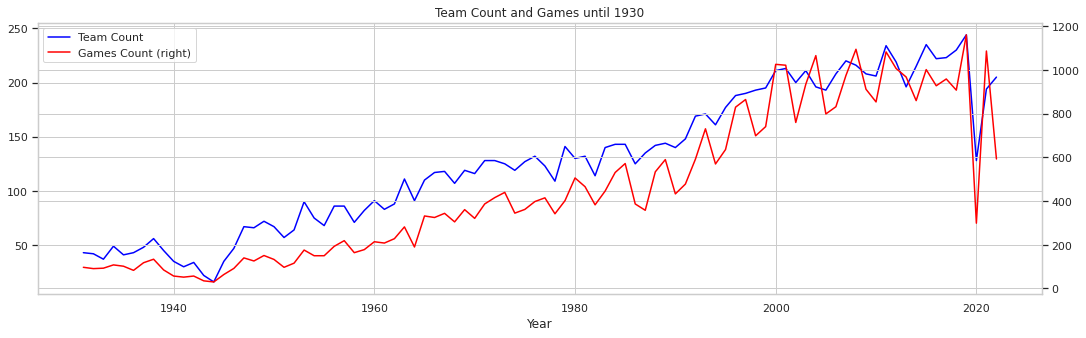

In [37]:
# Count how many different teams played international matches in each year
df_filtered = df_results[df_results['year'] > 1930]

list_team_count = []
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['teams_envolved'].to_list()
    countries = [m[0] for m in matches_list] # Gets the home team
    countries.extend([m[1] for m in matches_list]) # Gets the away team
    list_team_count.append(len(set(countries)))

series_team_count = pd.Series(index=df_filtered['year'].unique(), data=list_team_count)
series_game_count = df_filtered['year'].value_counts(sort = False)


plt.figure(figsize=(18,5))
plt.xlabel('Year')
plt.title("Team Count and Games until 1930")

ax1 = series_team_count.plot(color='blue', grid=True, label='Team Count')
ax2 = series_game_count.plot(color='red', grid=True, secondary_y=True, label='Games Count')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

<AxesSubplot:title={'center':'Percentage of games for continent'}>

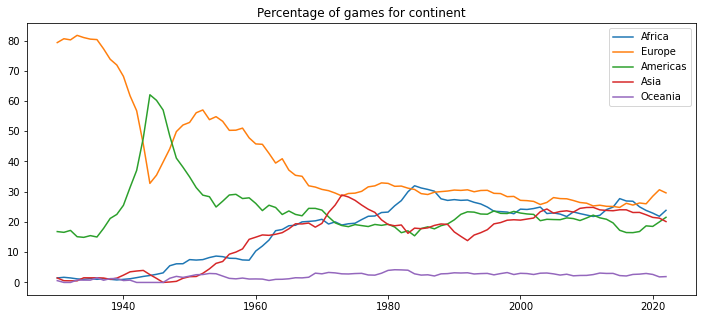

In [6]:
# What percentage of teams each continent had over the years
df_filtered = df_results[df_results['year'] > 1926]


list_continent_count = []
for y in df_filtered['year'].unique():
    matches_list = df_filtered.groupby(by = 'year').get_group(y)['continents_envolved'].to_list()
    continents = [m[0] for m in matches_list] # Gets the home team continent
    continents.extend([m[1] for m in matches_list]) # Gets the away team continent
    # Count of many of each continent we have
    africa = len([a for a in continents if a == 'Africa'])
    europe = len([a for a in continents if a == 'Europe'])
    americas = len([a for a in continents if a == 'Americas'])
    asia = len([a for a in continents if a == 'Asia'])
    oceania = len([a for a in continents if a == 'Oceania'])
    not_found = len([a for a in continents if a == 'not found'])

    list_continent_count.append([africa, europe, americas, asia, oceania, not_found])

df_contient_count = pd.DataFrame(index=df_filtered['year'].unique(), 
                                data=list_continent_count, 
                                columns = ['Africa', 'Europe', 'Americas', 'Asia', 'Oceania', 'not found'])

# Sum to get the total for each year
df_contient_count['total'] = df_contient_count.sum(axis=1)

# Calculate the roling mean of 4 years to have a smoother plot
df_contient_count = df_contient_count.rolling(4).mean().dropna()

# Calculate the percentage for each year
for c in [c for c in df_contient_count.columns if c != 'total']:
    df_contient_count[c] = df_contient_count.apply(lambda x: round(100*(x[c]/x['total']),2), axis = 1)

xticks_values = np.arange(1930, 2026, 4).tolist()
df_contient_count[['Africa', 'Europe', 'Americas', 'Asia', 'Oceania']].plot(figsize=(12,5),
                                                                            title = "Percentage of games for continent",
                                                                            xticks = xticks_values)

<AxesSubplot:title={'center':'Percentage of matches with different continents teams'}>

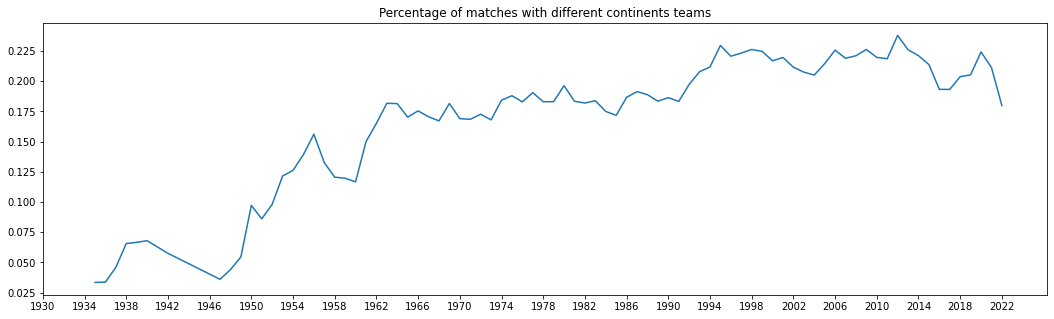

In [7]:
# Teams from diffent continent play with each other more or less they did in the past
# Count how many different teams played international matches in each year
df_filtered_continent = df_results[(df_results['year'] > 1930) & (df_results['same_continent'] == 'n')]
df_filtered = df_results[df_results['year'] > 1930]

series_diff_continents_count = df_filtered_continent['year'].value_counts(sort = False)
series_game_count = df_filtered['year'].value_counts(sort = False)

# Plot the rolling mean to get a smoother value
xticks_values = np.arange(1930, 2026, 4).tolist()
(series_diff_continents_count/series_game_count).dropna().rolling(4).mean().dropna().plot(figsize=(18,5),
                                                                                          title = "Percentage of matches with different continents teams",
                                                                                          xticks = xticks_values)

<AxesSubplot:title={'center':'Percentage of matches Europeans vs Americans'}>

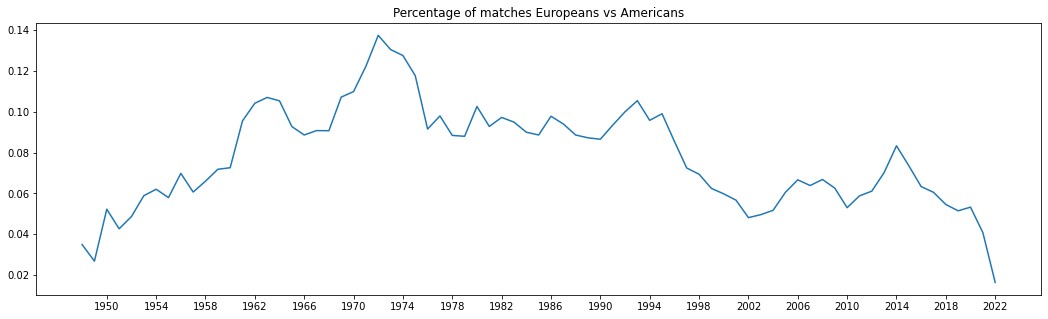

In [42]:
# European and American teams now play less with each other

# Total of games that had at least one european or one american
df_america_or_europe = df_results[(df_results['year'] > 1930) & ((df_results['home_team_continent'] == 'Americas') | 
                                                                (df_results['home_team_continent'] == 'Europe') | 
                                                                (df_results['away_team_continent'] == 'Americas') |
                                                                (df_results['away_team_continent'] == 'Europe'))]

# Total of games that Amreicans and Europeans play each other
df_america_vs_europe = df_results[(df_results['year'] > 1930) & (((df_results['home_team_continent'] == 'Americas') & 
                                                                (df_results['away_team_continent'] == 'Europe')) | 
                                                                ((df_results['home_team_continent'] == 'Europe') & 
                                                                (df_results['away_team_continent'] == 'Americas')))]


america_or_europe_count = df_america_or_europe['year'].value_counts(sort = False)
america_vs_europe_count = df_america_vs_europe['year'].value_counts(sort = False)

# Plot the rolling mean to get a smoother value
xticks_values = np.arange(1950, 2026, 4).tolist()
(america_vs_europe_count/america_or_europe_count).dropna().rolling(4).mean().dropna().plot(figsize=(18,5),
                                                                                          title = "Percentage of matches Europeans vs Americans",
                                                                                          xticks = xticks_values)

<AxesSubplot:title={'center':'Percentage of teams that win games'}, xlabel='year'>

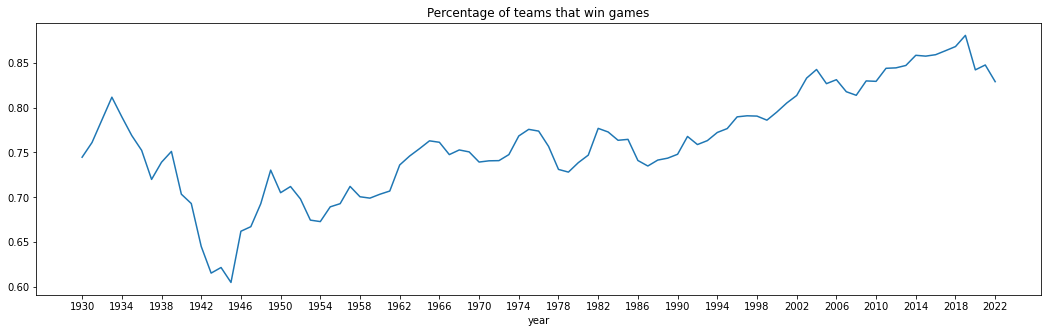

In [17]:
# Did more different teams win games today than in the past?
df_filtered = df_results[df_results['year'] > 1926]

# Quantos times venceram / total de times que jogou

df_list_count = []
for y in df_filtered['year'].unique():
    df_year = df_filtered.groupby(by = 'year').get_group(y)
    matches_list = df_year['teams_envolved'].to_list()
    countries = [m[0] for m in matches_list] # Gets the home team
    countries.extend([m[1] for m in matches_list]) # Gets the away team
    total_countries = len(set(countries))
    winning_teams_list = []
    for i,row in df_year.iterrows():
        if (row['outcome'] == 'H'): # Home teams wins
            winning_teams_list.append(row['home_team'])
        elif(row['outcome'] == 'A'): # Away team wins
            winning_teams_list.append(row['away_team'])
    total_winners = len(set(winning_teams_list)) # Gets unique countries that win at least one game
    df_list_count.append([y,total_countries,total_winners])

df_winners = pd.DataFrame(df_list_count, columns = ['year', 'total_countries', 'total_winners'])

df_winners['ratio'] = df_winners['total_winners'] / df_winners['total_countries'] 

xticks_values = np.arange(1930, 2026, 4).tolist()
df_winners.set_index('year').rolling(4).mean().dropna()['ratio'].plot(figsize=(18,5),
                                                                        title = "Percentage of teams that win games",
                                                                        xticks = xticks_values)


### How is the performance of a winning world cup team in the years the preceed the tournament?

In [8]:
df_wc_games = pd.read_csv("data/WorldCupMatches.csv").dropna()
df_wc_winners = pd.read_csv("data/WorldCups.csv").dropna()

df_wc_games['Year'] = df_wc_games['Year'].apply(int)
df_wc_games['Datetime'] = pd.to_datetime(df_wc_games['Datetime']).apply(lambda x: x.date())
df_wc_winners['Winner'] = df_wc_winners['Winner'].apply(lambda x: 'Germany' if x.__contains__('Germany') else x)

# Get the first and last day of the world cup
wc_start_end_list = []
for y in df_wc_games['Year'].unique():
    df_year = df_wc_games.groupby(by = 'Year').get_group(y)
    winner = df_wc_winners.groupby(by = 'Year').get_group(y)['Winner'].to_list()[0]
    wc_start_end_list.append([y, df_year['Datetime'].min(), df_year['Datetime'].max(), winner])

# The data only goes until 2014, so we manually add the Data from 2018
wc_start_end_list.append([2018, datetime(2018,6,14).date(), datetime(2018,7,15).date(), 'France'])

df_wc_start_end = pd.DataFrame(wc_start_end_list, columns = ['year', 'date_start', 'date_end','winner'])

# Get a dictionary that has the Country names as Keys and the Continent as Values
total_unique_countries = pd.concat([df_results['home_team'], df_results['away_team']]).unique()
dict_country_continent = {}
for c in total_unique_countries:
    try: 
        dict_country_continent[c] = df_results[df_results['home_team'] == c]['home_team_continent'].unique()[0]
    except:
        # If the team never had a game playing home
        dict_country_continent[c] = df_results[df_results['away_team'] == c]['away_team_continent'].unique()[0]

# Adding the continents
df_wc_start_end['continent'] = df_wc_start_end['winner'].apply(lambda x: dict_country_continent[x])

In [9]:
df_wc_start_end.head(5)

,year,date_start,date_end,winner,continent
0,1930,1930-07-13,1930-07-30,Uruguay,Americas
1,1934,1934-05-27,1934-06-10,Italy,Europe
2,1938,1938-06-04,1938-06-19,Italy,Europe
3,1950,1950-06-24,1950-07-16,Uruguay,Americas
4,1954,1954-06-16,1954-07-04,Germany,Europe


#### How many games, wins, losses, draws?

In [10]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    future_wc_winner = df_wc_start_end['winner'][i] # team that end up winning the WC

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(future_wc_winner))) &
                        (df_results['date'] > df_wc_start_end[df_wc_start_end['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == future_wc_winner): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, future_wc_winner, total_games_played, w, d, l])
    # print(df_wc_start_end['year'][i-1],df_wc_start_end['year'][i], df_wc_start_end['winner'][i])

df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'winner', 'games_played', 'wins', 'draws', 'losses'])

In [11]:
def show_values(axs, orient="v", space=.01):
    """
    Function extracted from: https://www.statology.org/seaborn-barplot-show-values/
    """
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

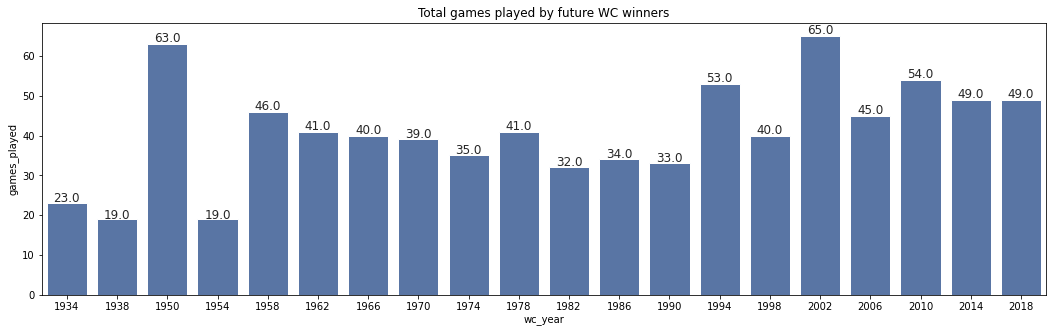

In [12]:
plt.figure(figsize=(18,5))
plt.title("Total games played by future WC winners")
sns.set_theme(style="whitegrid")
p = sns.barplot(data = df_wc_history, x= 'wc_year', y='games_played', color = 'b')

#show values on barplot
show_values(p)

<AxesSubplot:title={'center':'Percentage of wins, draws, losses'}, xlabel='wc_year'>

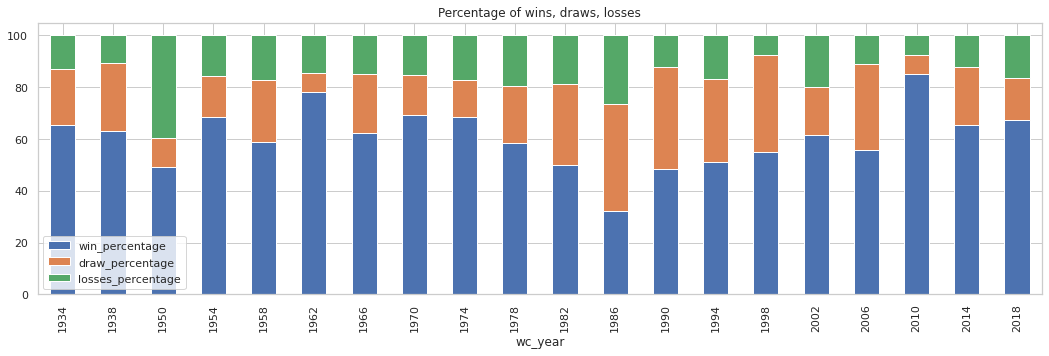

In [13]:
df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

df_wc_history.drop(columns = ['winner', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = "Percentage of wins, draws, losses")

#### How is the performance in the year before the WC

<AxesSubplot:title={'center':'Percentage of wins, draws, losses'}, xlabel='wc_year'>

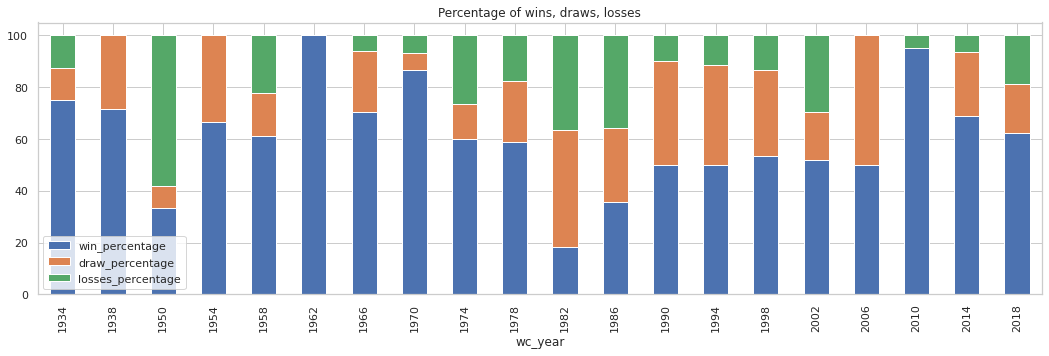

In [14]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    future_wc_winner = df_wc_start_end['winner'][i] # team that end up winning the WC

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(future_wc_winner))) &
                        (df_results['date'] > datetime(end_cycle_year - 1,1,1).date()) & # greater than the beginign of the year that preceds the WC
                        (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == future_wc_winner): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, future_wc_winner, total_games_played, w, d, l])
    # print(df_wc_start_end['year'][i-1],df_wc_start_end['year'][i], df_wc_start_end['winner'][i])

df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'winner', 'games_played', 'wins', 'draws', 'losses'])

df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

df_wc_history.drop(columns = ['winner', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = "Percentage of wins, draws, losses")

#### When Brazil and Argentina won WC, did they play more with europeans in their preparation?

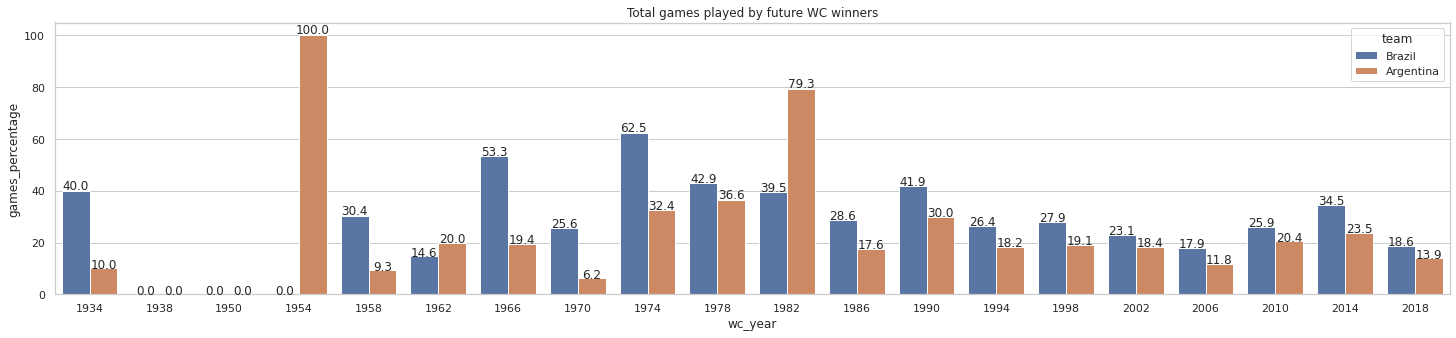

In [15]:
wc_history_list = []
for i in range(1,len(df_wc_start_end)):
    start_cycle_year = df_wc_start_end['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end['year'][i] # wc year, that ends the wc cycle
    for t in ['Brazil','Argentina']:
        # Filtering to get Brazil and Argentina game history for each WC cycle
        df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(t))) &
                            (df_results['date'] > df_wc_start_end[df_wc_start_end['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                            (df_results['date'] < df_wc_start_end[df_wc_start_end['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc
        total_games_played = len(df_wc_cycle)
        # Filter to get only the games played against europeans
        games_against_europeans = len(df_wc_cycle[df_wc_cycle['continents_envolved'].apply(lambda x: True if 'Europe' in x else False)])
        wc_history_list.append([end_cycle_year, t, total_games_played, games_against_europeans])

df_br_ar_history = pd.DataFrame(wc_history_list, columns=['wc_year', 'team', 'total_games_played', 'games_against_europeans'])

df_br_ar_history['games_percentage'] = (df_br_ar_history['games_against_europeans'] / df_br_ar_history['total_games_played']).apply(lambda x: round(100*x,2))

plt.figure(figsize=(25,5))
plt.title("Total games played by future WC winners")
sns.set_theme(style="whitegrid")
p = sns.barplot(data = df_br_ar_history, x = 'wc_year', y = 'games_percentage', hue = 'team' )
#show values on barplot
show_values(p)

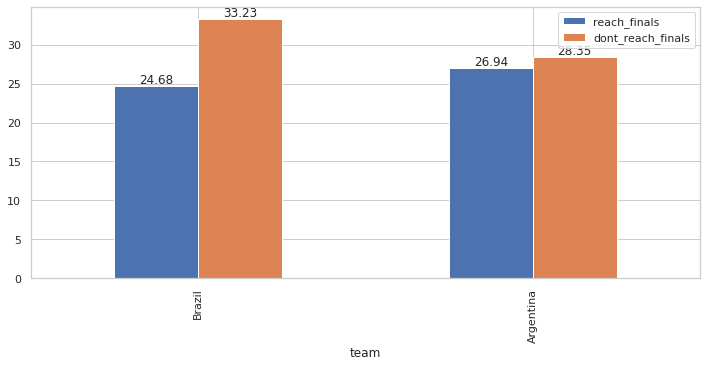

In [16]:
df_filtered = df_br_ar_history[df_br_ar_history['wc_year'] > 1950]

br_year_finals = [1950,1958,1962,1970,1994,1998,2002] # Years that brazil reach the WC final
ar_years_finals = [1978,1986,1990,2014] # Years that aregentina reach the WC final

dict_final_wc_years = {
    'Brazil':br_year_finals,
    'Argentina':ar_years_finals
}

df_list = []
for t in ['Brazil', 'Argentina']:
    # Percentage of games when the team reach the finals
    win_p = round(df_filtered[(df_filtered['team'] == t) & df_filtered['wc_year'].apply(lambda x: True if x in dict_final_wc_years[t] else False)]['games_percentage'].mean(),2)
    # Percentage of games when the team dont reach the finals
    loss_p = round(df_filtered[(df_filtered['team'] == t) & df_filtered['wc_year'].apply(lambda x: False if x in dict_final_wc_years[t] else True)]['games_percentage'].mean(),2)
    df_list.append([t,win_p,loss_p])


df_percenatge = pd.DataFrame(df_list, columns = ['team','reach_finals','dont_reach_finals'])

ax = df_percenatge.plot(kind = 'bar', x = 'team',figsize=(12,5))

for container in ax.containers:
    ax.bar_label(container)

### How Brazil is comming to the 2022 WC

#### How many wins, losses, draws?

<AxesSubplot:title={'center':'Brazil - Percentage of wins, draws, losses'}, xlabel='wc_year'>

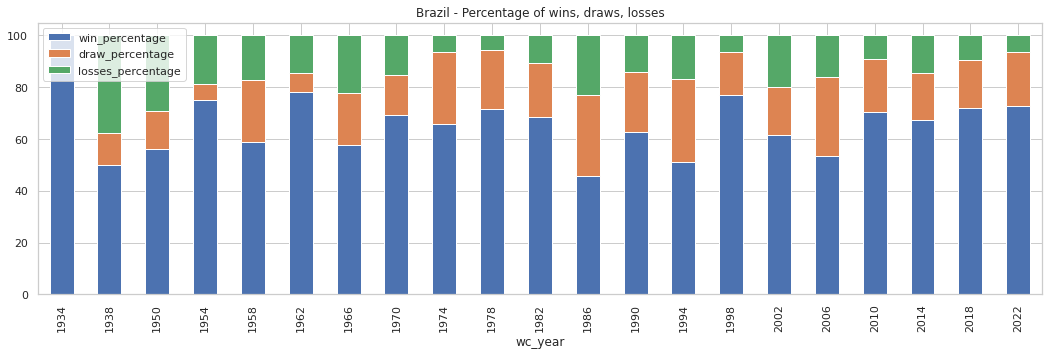

In [45]:
team = 'Brazil'

# Adding 2022 WC dates to get the data of the games after 2018
df_2022 = pd.DataFrame([[2022,datetime(2022,11,21).date(),datetime(2022,12,18).date(),'-','-']], columns = df_wc_start_end.columns, index = [21])
df_wc_start_end_2022 = pd.concat([df_wc_start_end,df_2022])

wc_history_list = []
for i in range(1,len(df_wc_start_end_2022)):
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    total_games_played = len(df_wc_cycle)
    w = 0
    l = 0
    d = 0
    for t in df_wc_cycle['winning_team']:
        if (t == team): # How many wins the team had
            w+=1
        elif (t == '-'): # How many draws the team had
            d += 1
        else:
            l += 1 # How many losses the team had

    wc_history_list.append([end_cycle_year, team, total_games_played, w, d, l])

df_wc_history = pd.DataFrame(wc_history_list, columns = ['wc_year', 'team', 'games_played', 'wins', 'draws', 'losses'])

df_wc_history['win_percentage'] = (df_wc_history['wins'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['draw_percentage'] = (df_wc_history['draws'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))
df_wc_history['losses_percentage'] = (df_wc_history['losses'] / df_wc_history['games_played']).apply(lambda x: round(100*x,2))

df_wc_history.drop(columns = ['team', 'games_played', 'wins', 'draws', 'losses']).set_index('wc_year').plot(kind = 'bar',
                                                                                                                 stacked=True,
                                                                                                                 figsize=(18,5),
                                                                                                                 title = f"{team} - Percentage of wins, draws, losses")

#### What percentage of the points possible it gets?

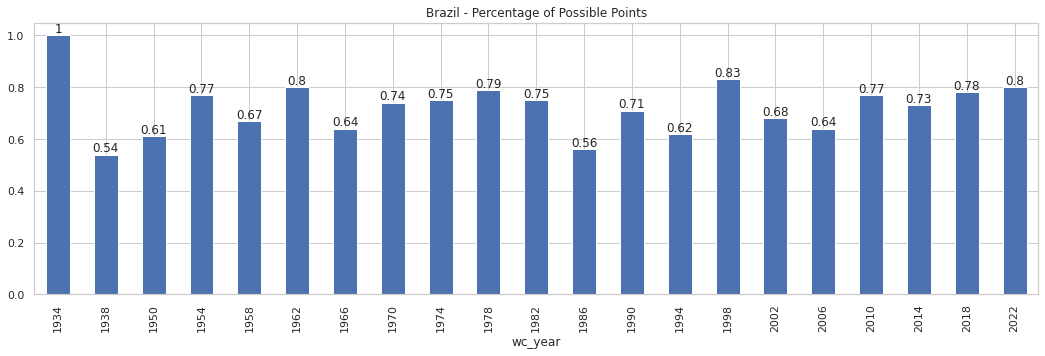

In [56]:
df_wc_history['possible_points'] = df_wc_history['games_played']*3
df_wc_history['obtained_points'] = df_wc_history['wins']*3 + df_wc_history['draws']
df_wc_history['points_ratio'] = (df_wc_history['obtained_points'] / df_wc_history['possible_points']).apply(lambda x: round(x,2))


ax = df_wc_history.set_index('wc_year')['points_ratio'].plot(kind = 'bar' ,figsize=(18,5), title = f'{team} - Percentage of Possible Points')

for container in ax.containers:
    ax.bar_label(container)

#### Which tournaments they played in the WC preparation?

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

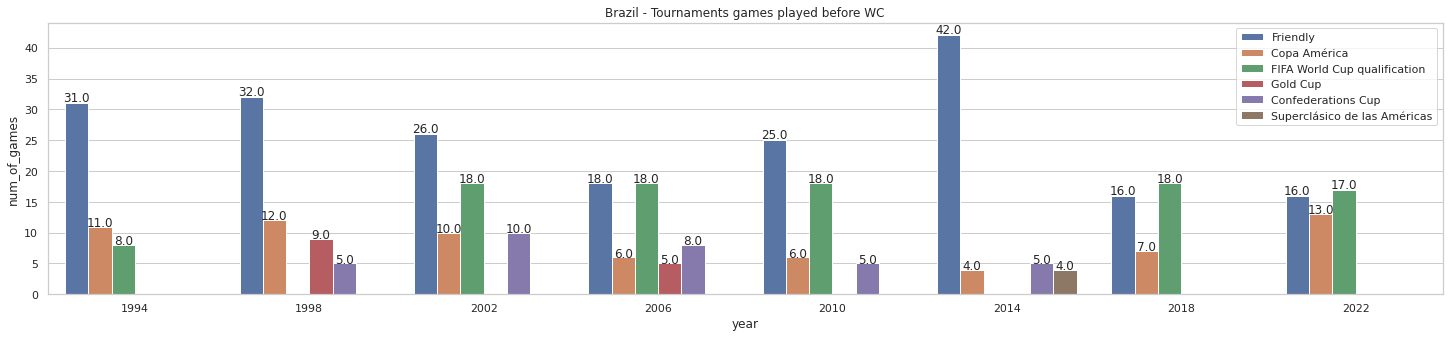

In [80]:
wc_history_list = []
df_tournaments = pd.DataFrame()
for i in range(14,len(df_wc_start_end_2022)): # Starting at the 1994 WC
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    df_tournaments_year = df_wc_cycle['tournament'].value_counts().reset_index()
    df_tournaments_year['year'] = end_cycle_year
    df_tournaments = pd.concat([df_tournaments, df_tournaments_year])

df_tournaments.rename(columns = {'index':'tournament','tournament':'num_of_games'}, inplace = True)

# Filtering tournaments with less than 4 games
df_tournaments = df_tournaments[df_tournaments['num_of_games'] > 3]

plt.figure(figsize=(25,5))
plt.title(f"{team} - Tournaments games played before WC")
sns.set_theme(style="whitegrid")

p = sns.barplot(data = df_tournaments,
            x = 'year',
            y = 'num_of_games',
            hue = 'tournament')
plt.legend(loc='upper right')
#show values on barplot
show_values(p)

#### Which continents Brazil played against

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


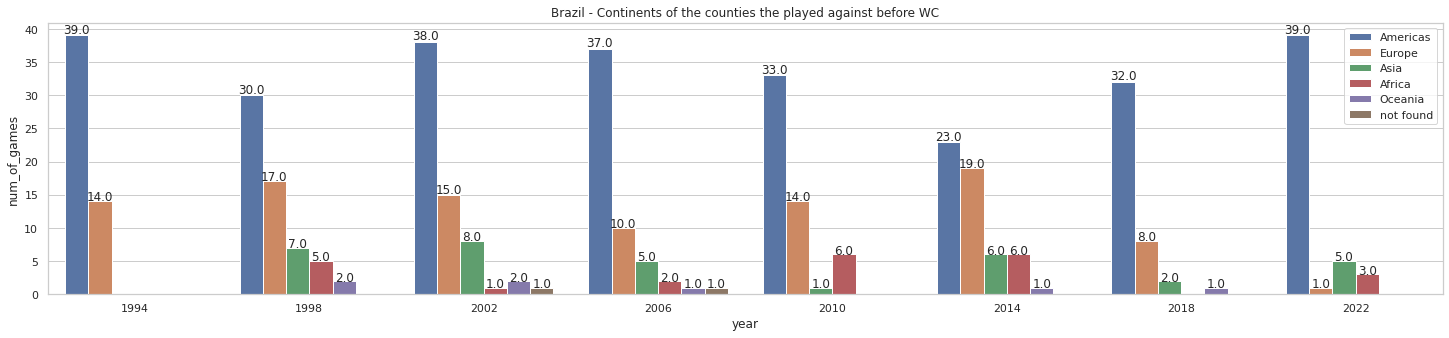

In [92]:
wc_history_list = []
df_continents = pd.DataFrame()
for i in range(14,len(df_wc_start_end_2022)): # Starting at the 1994 WC
    start_cycle_year = df_wc_start_end_2022['year'][i-1] # year that start the next wc cycle
    end_cycle_year = df_wc_start_end_2022['year'][i] # wc year, that ends the wc cycle

    df_wc_cycle = df_results[(df_results['teams_envolved'].apply(lambda x: x.__contains__(team))) &
                        (df_results['date'] > df_wc_start_end_2022[df_wc_start_end_2022['year'] == start_cycle_year]['date_end'].max()) & # greater than the end of last WC
                        (df_results['date'] < df_wc_start_end_2022[df_wc_start_end_2022['year'] == end_cycle_year]['date_start'].min())]  # smaller than the begging of current wc

    # Get the continents of the countries that the team played on that WC cycle
    df_continents_year = df_wc_cycle['teams_envolved'].apply(lambda x: dict_country_continent[[t for t in x if t != team][0]]).value_counts().reset_index()
    df_continents_year['year'] = end_cycle_year
    df_continents = pd.concat([df_continents, df_continents_year])

df_continents.rename(columns = {'index':'continents','teams_envolved':'num_of_games'}, inplace = True)


plt.figure(figsize=(25,5))
plt.title(f"{team} - Continents of the counties the played against before WC")
sns.set_theme(style="whitegrid")

p = sns.barplot(data = df_continents,
            x = 'year',
            y = 'num_of_games',
            hue = 'continents')
plt.legend(loc='upper right')
#show values on barplot
show_values(p)